##ライブラリのインポート
畳み込みスパース表現をnumpyだけで自作する頭が悪いノートブックはこちらです。

まず今回使うライブラリをインポートします

In [26]:
import numpy as np
import matplotlib.pyplot as plt

##データセットのダウンロード
原画像 ${s}_k \in \mathbb{R}^{N \times N}$をM枚の辞書 $d_m \in \mathbb{R}^{B \times B}$と係数マップ$x_{k,m} \in \mathbb{R}^{N \times N}$の畳み込みで近似する.
$$s_k = \sum_{m=1}^{M}d_m * x_{k,m}$$
今回使う画像はみんな大好きfashion mnistのデータセットの画像$K$枚. $K$の値は各自好きに設定してください.大きすぎると死んでしまうので程々に.

データの前処理として,各ピクセルの値を[0, 1]の範囲に正規化します.これは元々のピクセルの値が[0, 255]なので配列の全要素を255で割れば実現できます.

tensorflow経由でダウンロードします.

In [27]:
#データセットのダウンロード

K = 10 #fashion mnistの中から今回使う画像の枚数を指定する

from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

S = x_train[:K] #pythonのスライス, これでK枚の画像を取得できた
S = S / 255 #ピクセルの正規化

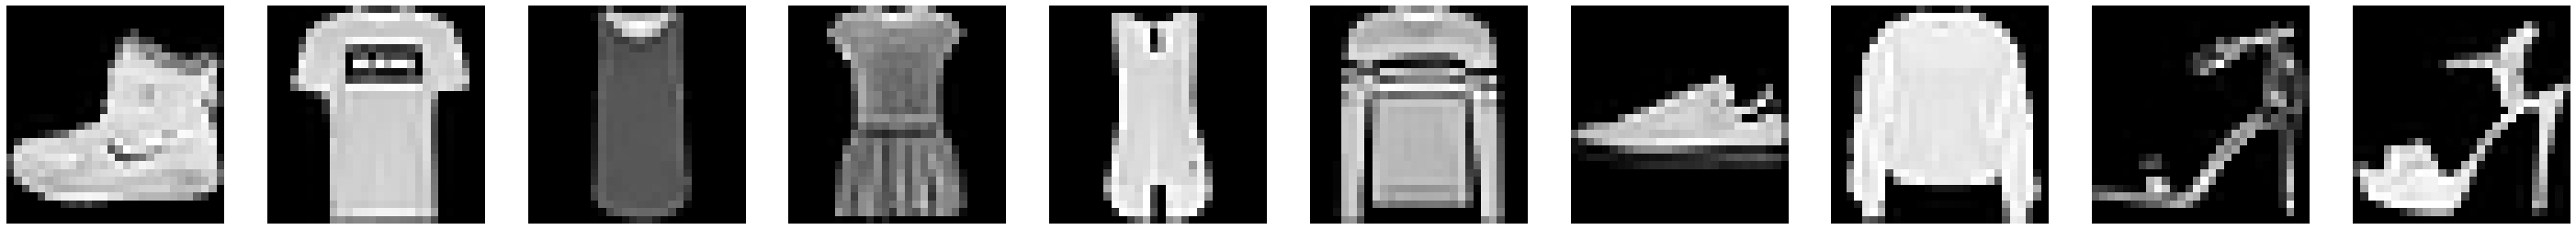

In [28]:
#K枚の画像の表示
fig = plt.figure(figsize=(K*5, 5))

for k in range(K):
  ax = fig.add_subplot(1, K, k+1) 
  ax.imshow(S[k], cmap="gray")
  ax.axis("off")
plt.show()

##定数の定義
次に今回使う定数を宣言していきます. 基本的には黒木様の資料と同じようになるように合わせていますが一部異なっているので注意してください.

$N$ : 画像の縦（または横）のピクセル数. 黒木さんの資料だと全画素数となっているので注意.

$M$ : 作成する辞書の枚数. （黒木さん資料と同じ）

$B$ : 作成する辞書の縦（または横）のピクセル数. 黒木さんの資料だと全画素数になっているので注意.

$K$ : 使用する原画像の枚数. これは上で定義したものをこれからも使う.

変数も同様に黒木様の資料に合うように定義していますが、画像は平滑化（flatten）せずに扱うので次元が増えています.

$S \in \mathbb{R}^{K \times N \times N}$ : 原画像の行列

$D \in \mathbb{R}^{M \times N \times N}$ : 辞書の行列, 実際の辞書は$\mathbb{R}^{M \times B \times B}$でそれ以外の部分は0で埋めている.計算できるように$D$を$\mathbb{R}^{M \times N \times N}$にしているが, 実際重要な部分は$\mathbb{R}^{M \times B \times B}$であることに注意.

$X \in \mathbb{R}^{K \times M \times N \times N}$ : 係数マップの行列

In [155]:
N = 28 #fashion mnistの画像は(28, 28)の行列
M = 8 #辞書の枚数
B = 2 #辞書の縦（または横）の画素数

##辞書と係数マップの初期化
それぞれの初期化方法は次のようにしている. これが本当に正しいのかはわからないから要検討.

$D$ : $\mathbb{R}^{M \times B \times B}$ は平均$0$, 分散$1$に正規分布で初期化する.それ以外のところは $0$ で埋める.

$X$ : $0$で初期化する.

In [156]:
#辞書Dの初期化
D = np.random.normal(loc=0, scale=1, size=(M, B, B)) #D[:, :B, :B]を標準正規分布で初期化
D = np.pad(D, ((0, 0), (0, N-B), (0, N-B))) #D[:, B:N, B:N]を0で埋める

In [157]:
#係数マップの初期化
X = np.zeros(shape=(K, M, N, N)) #0で初期化

##定式化
凸最適化に定式化した式は次のようになっている.

$${\underset{\rm{d_m, x_{k,m}}}{\rm{argmin}}} \frac{1}{2}\sum_{k=1}^{K}||\sum_{m=1}^{M}d_m * x_{k,m} - s_k||_2^2 + \lambda \sum_{k=0}^{K}\sum_{m=0}^{M}||x_{k,m}||_1 \qquad s.t. d_m \in C_{PN} \\ 
C_{PN} = \{{y \in \mathbb{R}^{N \times N} | (I_N - PP^T)y=0, ||y||_2 \leq1}\} \\
P = \left(
\begin{array}{c}
I_{N_d} \\
0
\end{array}
\right)
$$


$d_m \in C_{PN}$の意味が初見では分かりにくいのでメモ

$d_m$は計算ができるように$\mathbb{R}^{N \times N}$としている。しかし、実際の辞書のサイズは$\mathbb{R}^{B \times B}$. 整合性が取れるように辞書と関係がないそれ以外の場所が0になっている行列の集合を$C_{PN}$としている.

逆に辞書に関係がない場所が0以外の数字になっている場合は$y \neq PP^Ty$となるため$C_{PN}$の要素にならない.

$||y||_2 \leq1$は辞書が大きくなりすぎないようにするための正規化.

##係数の最適化
$${\underset{\rm{x_{k,m}}}{\rm{argmin}}} \frac{1}{2}\sum_{k=1}^{K}||\sum_{m=1}^{M}d_m * x_{k,m} - s_k||_2^2 + \lambda \sum_{k=0}^{K}\sum_{m=0}^{M}||x_{k,m}||_1$$

係数マップは画像ごとに最適化を行えば良いので原画像$k$についての係数の最適化の式は次のようになる. 実際はこれを各$k$について最適化を行う.

$${\underset{\rm{x_{k,m}}}{\rm{argmin}}} \frac{1}{2}||\sum_{m=1}^{M}d_m * x_{k,m} - s_k||_2^2 + \lambda \sum_{m=0}^{M}||x_{k,m}||_1$$

また$D_m'X_{k,m} = d_m*x_{k,m}$となるような行列$D_m'$を考える.（この行列は具体的に求める必要はない. そのような行列があることだけが重要.）

$D' = (D_1', D_2', \cdots, D_M'), X_k = \left(
\begin{array}{c}
X_{k,1} \\
X_{k,2} \\
\vdots \\
X_{k,M}
\end{array}
\right)$と定義してあげれば
$$\sum_{m}^{M}d_m * x_{k,m} = D'X_k$$

ここで注意するべきところが、我々が上で定義した行列$D \in \mathbb{R}^{M \times N \times N}$とここで新しく定義した$D'$は定義のされ方が全く違う.（別物と思った方が実装する際に困りにくい.）$D$はただ単に$M$枚の$N \times N$の辞書を並べただけ.

つまり上式は次のように表すことができる.
$${\underset{\rm{x_{k,m}}}{\rm{argmin}}} \frac{1}{2}||\sum_{m=1}^{M}D'X_k - s_k||_2^2 + \lambda ||X_{k}||_1$$

ADMMで最適ができる形に変形する
$${\underset{\rm{x_{k,m}}}{\rm{argmin}}} \frac{1}{2}||\sum_{m=1}^{M}D'X_k - s_k||_2^2 + \lambda ||Y_{k}||_1 \qquad s.t. X_k=Y_k$$

ADMMを用いて最適化する.


$n$ステップ目の更新式は次のように表すことができる.

$$X_k^{(n+1)} = \underset{X_k}{\rm{argmin}}\frac{1}{2}||\sum_{m=1}^{M}D'X_k - s_k||_2^2 + \frac{\rho}{2}||X_k - Y_k^{(n)}+U_k^{(n)}||_2^2 \\
Y_k^{(n+1)} = \underset{Y_k}{\rm{argmin}}\lambda||Y_k||_1 + \frac{\rho}{2}||X_k^{(n+1)}-Y_k+U_k^{(n)}||_2^2 \\
U_k^{(n + 1)} = U_k^{(n)} + X_k^{(n+1)}-Y_k^{(n)}$$

ADMMで使うパラメータ$\lambda$と$\rho$を設定する. 好きな値に設定してください.

In [158]:
Lam = 0.0001
Rho = 1

###$Y$と$U$の初期化
まず最適化を始める前に$Y = X$, $U = 0$に初期化する


In [159]:
#変数の初期化
Y = X #(K, M, N, N)
U = np.zeros(shape=(K, M, N, N)) #(K, M, N, N)

###$X$の更新式
これは全ての項が$X_k$で微分可能でかつ下に凸な関数なので$X_k$について微分した値が$0$になるところが最小値になるのでその時の$X_k$を求めれば良い.

$$
D'^T(D'X_k - s_k) + \rho(X_k - Y_k^{(n)} + U_k^{(n)})=0 \\
\Longleftrightarrow (D'^TD' + \rho I)X_k = D'^Ts_k + \rho(Y_k^{(n)} - U_k^{(n)}) \\
\Longleftrightarrow X_k =  (D'^TD' + \rho I)^{-1}\{D'^Ts_k + \rho(Y_k^{(n)} - U_k^{(n)})\}
$$

これを計算するのはだいぶきつい（特に逆行列を計算しないといけないところ）なのでFFTしてフーリエ領域で求める.

FFTした後の式は次のようになる.
$$
\hat{X_k} = (\hat{D}'^T\hat{D}' + \rho I)^{-1}\{\hat{D}'^T\hat{s_k} + \rho(\hat{Y_k}^{(n)}-\hat{U_k}^{(n)})\}
$$

フーリエ変換後の行列の定義は次のように定義されている.
$$
\hat{D'} = (\rm{diag}(\hat{d_1})), \rm{diag}(\hat{d_2}), \cdots, \rm{diag}(\hat{d_M}))
$$
しかしこの行列サイズは非常に大きいので、メモリに乗らない可能性があり、もし乗ったとしてもその後の行列演算が大きすぎてできないので実装ではこの行列は使わずに一番初めに定義した$D$（$D'$とは全く違うことに注意）を使って計算していく.

とりあえず原画像$k=0$についての全ての変数を二次元フーリエ変換する.

In [160]:
k = 0
D_hat = np.fft.fft2(D,    norm="ortho") #(M, N, N)
S_hat = np.fft.fft2(S[k], norm="ortho") #(N, N)
Y_hat = np.fft.fft2(Y[k], norm="ortho") #(M, N, N)
U_hat = np.fft.fft2(U[k], norm="ortho") #(M, N, N)


$$
\hat{D}'\hat{X_k} = \mathcal{F}\left[\sum_{m=1}^{M}d_m \odot x_{k,m}\right] = \rm(\mathcal{F}[D] \odot \mathcal{F}[X_k], axis=m)
$$

実装としては$\mathcal{F}[D] \in \mathbb{R}^{M \times N \times N}$で$\mathcal{F}[X_k] \in \mathbb{R}^{K \times M \times N \times N}$なので要素積$\mathcal{F}[D] \odot \mathcal{F}[X_k] \in \mathbb{R}^{K \times M \times N \times N}$をした後に$M$の次元（axis$=$1）で和を取る.

また$\hat{D}'^{H}s_k$は次のように計算できる
$$
\hat{D}'^{H}s_k = \left(
\begin{array}{c}
\mathcal{F}[d_1^*] \odot \mathcal{F}[s_k] \\
\mathcal{F}[d_2^*] \odot \mathcal{F}[s_k] \\
\vdots \\
\mathcal{F}[d_M^*] \odot \mathcal{F}[s_k]
\end{array}
\right) \in \mathbb{R}^{M \times N \times N}
$$

実装するとこんな感じです. 変数$right\_side$に格納します

In [161]:
D_hat_conjugation = np.conjugate(D_hat) #D_hatの複素共役をとる, (M, N, N)
right_side = D_hat_conjugation * S_hat 

$right\_side$に$\rho(Y_k^{(n)} - U_k^{(n)})$も加えて次の式を完成させる.

$$
D'^Ts_k + \rho(Y_k^{(n)} - U_k^{(n)})
$$

In [162]:
right_side = D_hat_conjugation * S_hat + Rho * (Y_hat - U_hat) #(M, N, N)

最後に$(\hat{D}'^H\hat{D}' + \rho I)^{-1}$の計算を頑張る.
まずシャーマンモリソンの逆行列の補助定理がある.

$$
(A + BC)^{-1} = A^{-1} - A^{-1}B(I + CA^{-1}B)^{-1}CA^{-1}
$$

この定理を利用すると
$$
(\rho I + \hat{D}'^H\hat{D}') = \frac{1}{\rho}I-\frac{1}{\rho^2}\hat{D}'^H(I + \frac{1}{\rho}\hat{D}'\hat{D}'^H)^{-1}\hat{D}'
$$

ここで$\hat{D}'\hat{D}'^H$は対角行列になる. つまり逆行列は対角成分を逆数にすれば簡単に求めることができ計算できる. (辞書の場合はこれが$K=1$の場合にしか成り立たない。そこでコンセンサス方式を用いることで解くことができるようになる.) 対角行列とベクトルの行列積は対角成分を並べたベクトルとの要素積と同値.

$$
\rm{diag}(a_1, a_2, \cdots) \left(
\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
\end{array}
\right)
= \left(
\begin{array}{c}
a_{1} \\
a_{2} \\
\vdots \\
\end{array}
\right) \odot \left(
\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
\end{array}
\right)
$$

$\hat{X}_k$は次のように求めることができる

$$
X_k = \frac{1}{\rho}{reft\_side}-\frac{1}{\rho^2}\hat{D}'^H(I + \frac{1}{\rho}\hat{D}'\hat{D}'^H)^{-1}\hat{D}'{reft\_side}
$$

これを実装すると次のようになる. これはこれまでに説明したことの組み合わせを考えればわかるはず.

In [163]:
diag_inv = 1 / (1 + np.sum(D_hat * D_hat_conjugation, axis=0)/Rho) #(N, N)
X_hat = right_side / Rho - D_hat_conjugation * (diag_inv * np.sum(D_hat * right_side, axis=0))/Rho**2 #(M, N, N)

最後に逆フーリエ変換する. 型の関係から実数成分のみを取り出す.

In [164]:
X_k = np.fft.ifft2(X_hat, norm="ortho").real #計算機の誤差で若干虚数成分も残るが気にしない

###yの更新式
$$
Y_k^{(n+1)} = \underset{Y_k}{\rm{argmin}}\lambda||Y_k||_1 + \frac{\rho}{2}||X_k^{(n+1)}-Y_k+U_k^{(n)}||_2^2 
$$
これは微分ができないので近接写像を用いて最適化を行う. これはネットにも黒木さんの資料にもたくさん乗っているので導出は省略します.

これの更新式は次のようになる.

$$
Y_k^{(n+1)} = \rm{sign}(X_k^{(n+1)}+U_k^{(n)}) \odot \rm{max}(0, ||X_k^{(n+1)}+U_k^{(n)}||_2-\frac{\lambda}{\rho})
$$

実装したらこんな感じになる

In [165]:
V = X_k + U[k]
Y = np.sign(V) * np.clip(np.abs(V)-Lam/Rho, 0, float("inf")) #ソフト閾値関数で最適化

###Uの更新式
見たまんま実装すれば良いので省略

###係数マップを最適化するクラス
これまでのことをまとめたクラスを作る

In [166]:
import numpy as np

class Coef_optim:
    """
    係数マップを最適化する

    Attributes
    ----------
    N : int
        入力画像の縦（または横）の画素数
    M : int
        作成する辞書の枚数
    B : int
        辞書の縦（または横）の画素数
    K : int
        学習枚数
    Rho : int
        ADMMの係数
    S : np.array
        size = (K, N, N)
        畳み込みスパースで表したい元画像
    X : np.array
        size = (K, M, N, N)
        係数マップ
    Y : np.array
        size = (K, M, N, N)
    U : np.array
        size = (K, M, N, N)
        双対変数
    D : np.array
        size = (M, N, N)
    """

    def __init__(self, N, M, B, K, Rho, Lam, coef_loop, S, X):
        """
        Parameters
        ----------
        N : int
        入力画像の縦（または横）の画素数
        M : int
            作成する辞書の枚数
        B : int
            辞書の縦（または横）の画素数
        K : int
            学習枚数
        Rho : int
            ADMMの係数
        Lam : int
            最適化する時の係数
        coef_loop : int
            係数を最適化する時のループの回数
        S : np.array
            size = (K, N, N)
            畳み込みスパースで表したい元画像
        X : np.array
            size = (K, M, N, N)
            係数マップ
        """
        self.N = N 
        self.M = M
        self.B = B
        self.K = K
        self.Rho = Rho
        self.Lam = Lam
        self.coef_loop = coef_loop

        self.S = S
        self.X = X
        # self.reset_parameters
        
    def reset_parameters(self):
        """
        パラメータを初期化する関数
        """
        self.Y = self.X #制約条件のX-Y=0より
        self.U = np.zeros(shape=(self.K, self.M, self.N, self.N)) #双対変数Uの初期化


    def coef_update(self, D, iteration):
        """
        Parameters
        ----------
        D : np.array
            size = (M, N, N)
            辞書（係数の最適化をする際は定数として扱う）
        iteration : int
            係数マップの最適化回数

        Returns
        -------
        X : np.array
            size = (K, M, N, N)
            最適化した係数マップを返す
        """

        self.D = D

        self.reset_parameters()
        
        for i in range(iteration):
            #最適化を一回回す
            #画像ごとに最適化する
            for k in range(self.K):
                self.update_X(k)
                self.update_Y(k)
                self.update_U(k)
            
        return self.X
        
    def update_X(self, k):
        """
        Xを更新する.
        更新の流れ次のようになっている.
        1. D, S, Y, Uを2DでFFT. 正規化が必ず必要.
        2. 逆行列の補助定理を使いながら最適なXに更新する.
        3. 逆フーリエ変換して最適なXを計算する

        Parameters
        ----------
        k : int
            画像kについて最適化する
        """

        #1.
        D_hat = np.fft.fft2(self.D,    norm="ortho") #(M, N, N)
        S_hat = np.fft.fft2(self.S[k], norm="ortho") #(N, N)
        Y_hat = np.fft.fft2(self.Y[k], norm="ortho") #(M, N, N)
        U_hat = np.fft.fft2(self.U[k], norm="ortho") #(M, N, N)

        #2
        D_hat_conjugation = np.conjugate(D_hat) #(M, N, N)
        left_side = D_hat_conjugation * S_hat + self.Rho * (Y_hat - U_hat) #(M, N, N)
        diag_inv = 1 / (1 + np.sum(D_hat * D_hat_conjugation, axis=0)/self.Rho) #(N, N)
        X_hat = left_side / self.Rho - D_hat_conjugation * (diag_inv * np.sum(D_hat * left_side, axis=0))/self.Rho**2 #(M, N, N)

        #3.
        X = np.fft.ifft2(X_hat, norm="ortho").real #計算機の誤差で若干虚数成分も残るが気にしない
        self.X[k] = X #当該箇所のXの値を更新する

    def update_Y(self, k):
        """
        Yを近接写像を用いて行絵rつの要素ごとに最適化する.

        Parameters
        ----------
        k : int
            画像kについて最適化する
        """
        V = self.X[k] + self.U[k]
        self.Y[k] = np.sign(V) * np.clip(np.abs(V)-self.Lam/self.Rho, 0, float("inf")) #ソフト閾値関数で最適化
    
    def update_U(self, k):
        """
        Uを更新する.

        Parameters
        ----------
        k : int
            画像kについて最適化する
        """
        self.U[k] = self.U[k] + self.X[k] - self.Y[k]

##辞書の更新
実装の基本的な考え方は係数マップの時と同じ.
ただ一枚の画像を畳み込みで表す場合に限る. 複数枚の場合は係数マップの時になった対角行列による逆行列計算ができないためやり方を変える必要がある.一つのやり方はコンセンサス方式を使う方法だが、書くと長くなりそうなのでまたいつか描きます.今回実装は少しごまかしを入れています.

In [167]:
import numpy as np

class Dict_optim:
    """
    辞書を最適化する

    Attrubutes
    ----------
    N : int
        入力画像の縦（または横）の画素数
    M : int
        作成する辞書の枚数
    B : int
        辞書の縦（または横）の画素数
    K : int
        学習枚数
    Rho : int
        ADMMの係数
    S : np.array
        size = (K, N, N)
    D : np.array
        size = (M, N, N)
    G : np.array
        size = (M, N, N)
    U : np.array
        size = (M, N, N)
        双対変数
    X : np.array
        size = (K, M, N, N)
    """

    def __init__(self, N, M, B, K, Rho, Lam, dict_loop, S, D):
        """
        Parameters
        ----------
        N : int
        入力画像の縦（または横）の画素数
        M : int
            作成する辞書の枚数
        B : int
            辞書の縦（または横）の画素数
        K : int
            学習枚数
        Rho : int
            ADMMの係数
        Lam : int
            スパース性を表す係数
        dict_loop : int
            辞書のループ
        S : np.array
            size = (K, N, N)
            畳み込みスパースで表したい元画像
        D : np.array
            size = (M, N, N)
        """
        self.N = N 
        self.M = M
        self.B = B
        self.K = K
        self.Rho = Rho
        self.Lam = Lam
        self.dict_loop = dict_loop

        self.S = S
        self.D = D

    def reset_parameters(self):
        self.G = self.D #制約条件D-G=0より
        self.U = np.zeros(shape=(self.M, self.N, self.N)) #双対変数Uの初期化
    
    def dict_update(self, X, iteration):
        """
        Parameters
        ----------
        X : np.array
            size = (K, M, N, N)
            係数マップ
        iteration : int
            辞書の最適化を行う回数

        Returns
        -------
        D : np.array
            size = (M, N, N)
            最適化した辞書を返す
        """

        self.X = X

        self.reset_parameters()
        
        for i in range(iteration):
            self.update_D()
            self.update_G()
            self.update_U()

        return self.D

    def update_D(self):
        """
        辞書Dを更新する.
        更新の流れは次のようになっている.
        1. 複数の画像を一枚の画像にする. 本来はしてはいけないけどめんどくさいから代替案として採用. 極端に精度が落ちることはなさそうな気がする.
        2. X, S, G, Uを2DでFFT. 正規化が必ず必要.
        3. 逆行列の補助定理を使いながら最適なD_hatを計算する.
        4. 逆フーリエ変換して最適なDを計算する
        """

        #1. 
        tiled_X = np.sum(self.X, axis=0) #(M, N, N)
        tiled_S = np.sum(self.S, axis=0) #(N, N)

        #2.
        X_hat = np.fft.fft2(tiled_X, norm="ortho") #(M, N, N)
        S_hat = np.fft.fft2(tiled_S, norm="ortho") #(N, N)
        G_hat = np.fft.fft2(self.G,  norm="ortho") #(M, N, N)
        U_hat = np.fft.fft2(self.U,  norm="ortho") #(M, N, N)

        #3.
        X_hat_conjugation = np.conjugate(X_hat) #(M, N, N)
        left_side = X_hat_conjugation*S_hat + self.Rho * (G_hat - U_hat) #(M, N, N)
        diag_inv = 1 / (1 + np.sum(X_hat * X_hat_conjugation, axis=0)/self.Rho) #(N, N)
        D_hat = left_side/self.Rho - X_hat_conjugation * (diag_inv * np.sum(X_hat * left_side, axis=0))/self.Rho


        #4.
        self.D = np.fft.ifft2(D_hat, norm="ortho").real
    
    def update_G(self):
        """
        Gを近接写像で更新する

        PP^{T}YについてはY[:, N-B:N, N-B:N]を0パディングすることで実現できる
        ノルムの正規化はYのノルムを見て1より大きかったら正規化する
        """

        Y = self.D + self.U

        #PP^{T}は0パディングすればOK
        Y = np.pad(Y[:, :self.B, :self.B], ((0, 0), (0, self.N-self.B), (0, self.N-self.B)))

        #ノルムの正規化
        #もっと綺麗な書き方あるはずだけど妥協しました
        norm_Y = np.sum(np.sqrt(Y**2), axis=(1, 2)) #各辞書（m）のl2ノルムを取得
        for m, norm_Y_m in enumerate(norm_Y):
            if norm_Y_m < 1: #1よりノルムが小さい辞書は無視する
                continue
            Y[m] /= norm_Y_m
        self.G = Y
    
    def update_U(self):
        """
        Uを更新する
        """
        self.U = self.U + self.D - self.G

##畳み込みスパース表現の実行!
実際にfashion mnistのデータを使って実行してみる.
まずは各種定数の宣言から.

In [168]:
coef_loop = 5
dict_loop = 5
hole_loop = 10

In [169]:
#インスタンス化
coef_optim = Coef_optim(N, M, B, K, Rho, Lam, coef_loop, S, X)
dict_optim = Dict_optim(N, M, B, K, Rho, Lam, dict_loop, S, D)

In [170]:
for i in range(hole_loop):
    X = coef_optim.coef_update(D, coef_loop)
    D = dict_optim.dict_update(X, dict_loop)

##結果の可視化
得られた辞書と係数マップを可視化する

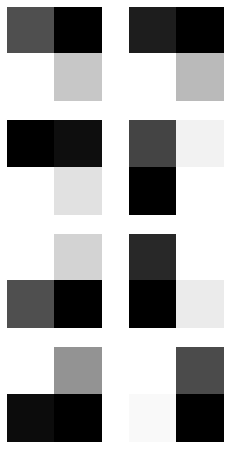

In [171]:
#辞書の可視化
fig = plt.figure(figsize=(2*2, 2*(M//2)))
for m in range(M):
    ax = fig.add_subplot(M//2, 2, m+1)
    ax.imshow(D[m, :B, :B], cmap="gray")
    ax.axis("off")
plt.show()

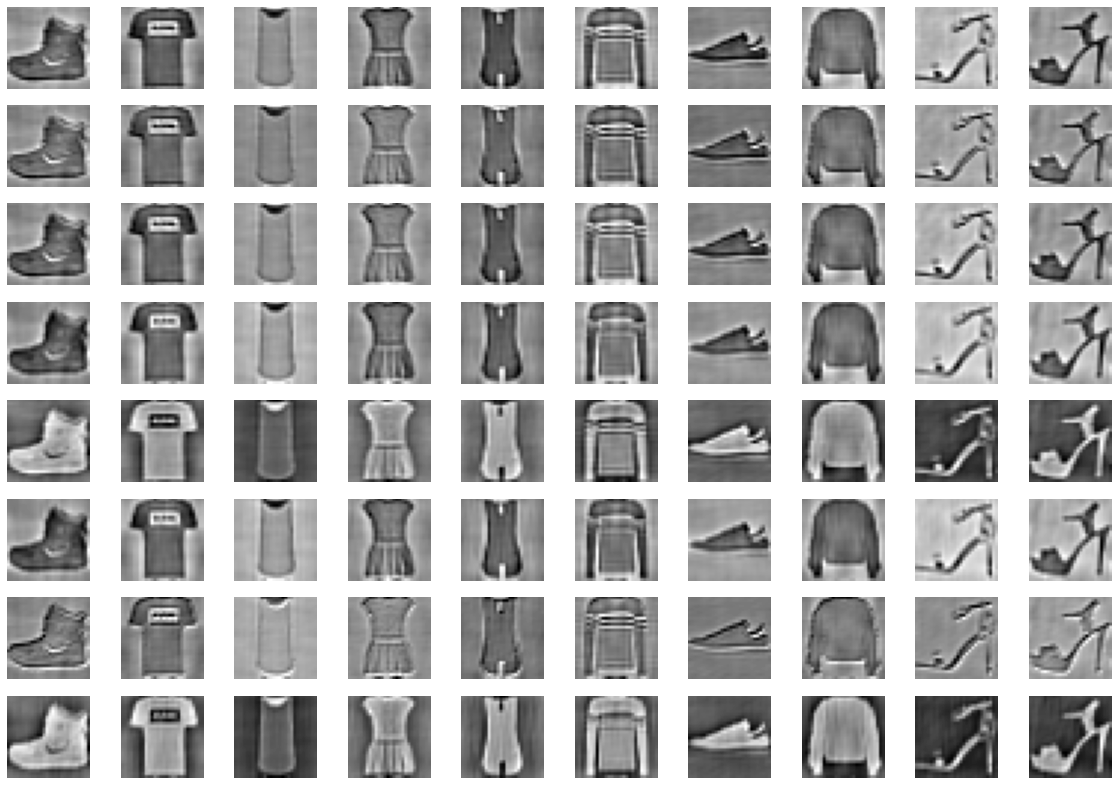

In [172]:
#係数マップの可視化
fig = plt.figure(figsize=(2*K, 2*(M)))
for coef_map in range(M):
    for image in range(K):
        ax = fig.add_subplot(M+1, K, (coef_map)*(K)+(image+1))
        ax.imshow(X[image, coef_map], cmap="gray")
        ax.axis("off")

###辞書と係数マップから画像を復元
辞書と係数マップをたたみ込んで（フーリエ領域で要素積）復元してみる

In [173]:
D_hat = np.fft.fft2(D, norm="ortho")
X_hat = np.fft.fft2(X, norm="ortho")

Image_hat = D_hat * X_hat
Image = np.sum(np.fft.ifft2(Image_hat, norm="ortho"), axis=1).real

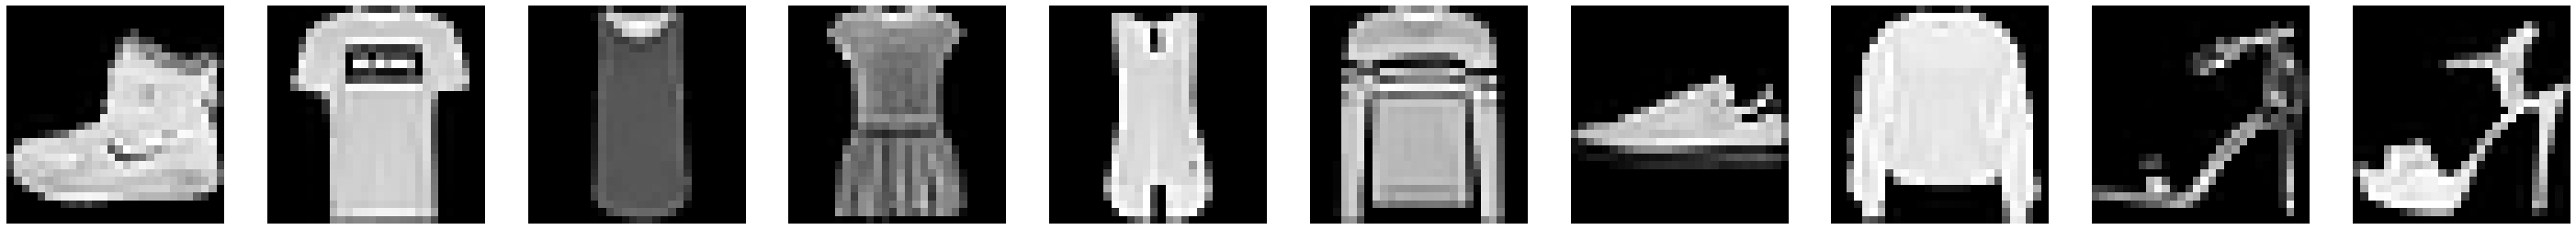

In [174]:
#原画像を可視化する

fig = plt.figure(figsize=(K*5, 5))

for k in range(K):
  ax = fig.add_subplot(1, K, k+1) 
  ax.imshow(S[k], cmap="gray")
  ax.axis("off")
plt.show()

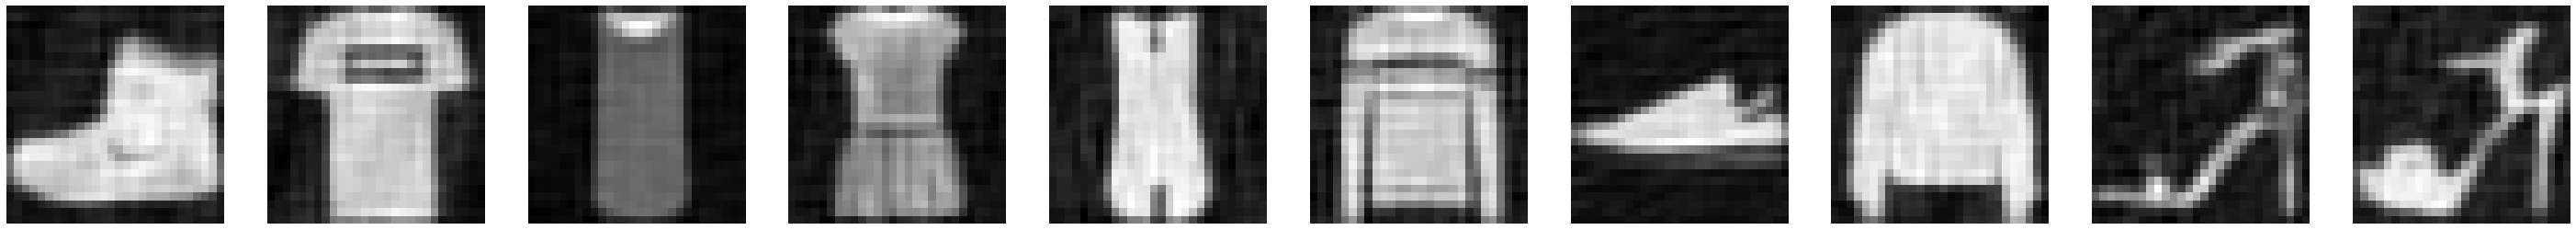

In [175]:
#復元した画像を可視化する
fig = plt.figure(figsize=(5*K, 5))
for k in range(K):
  ax = fig.add_subplot(1, K, k+1)
  ax.imshow(Image[k], cmap="gray")
  ax.axis("off")

もっと高解像度なデータで行う方が面白いです